In [136]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

In [137]:
recession_vs_yield = pd.read_csv('data/preprocessed_2.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))


#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
# data_max = recession_vs_yield.resample('Q-JAN', convention='end').agg('max').drop(columns = ['USREC'])
# data_min = recession_vs_yield.resample('Q-JAN', convention='end').agg('min').drop(columns = ['USREC'])
data_spread = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_spread = data_spread.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_spread, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]

In [138]:
data['USREC'] = data['USREC'].shift(periods = -1)
data = data.iloc[:-1,:]

In [139]:
data.corr()['USREC'].sort_values(ascending=False)

USREC                        1.000000
Value_3mon_std               0.394093
Value_3mon_split             0.387935
spread_std                   0.375029
Bad time to buy_mean         0.373564
spread_split                 0.366512
Value_3mon_mean              0.298457
Good time to buy_std         0.258980
Good time to buy_split       0.255428
Relative_split               0.252663
Relative_std                 0.248961
Value_10yr_std               0.248734
Value_10yr_split             0.241937
Value_10yr_mean              0.232248
Bad time to buy_std          0.211789
Bad time to buy_split        0.204102
housing market_std           0.115726
housing market_split         0.112824
Uncertain - depends_mean     0.099920
Uncertain - depends_std      0.074779
Uncertain - depends_split    0.068519
Value_split                  0.058202
Value_std                    0.051227
Value_mean                  -0.017998
housing market_mean         -0.053930
spread_mean                 -0.225224
Relative_mea

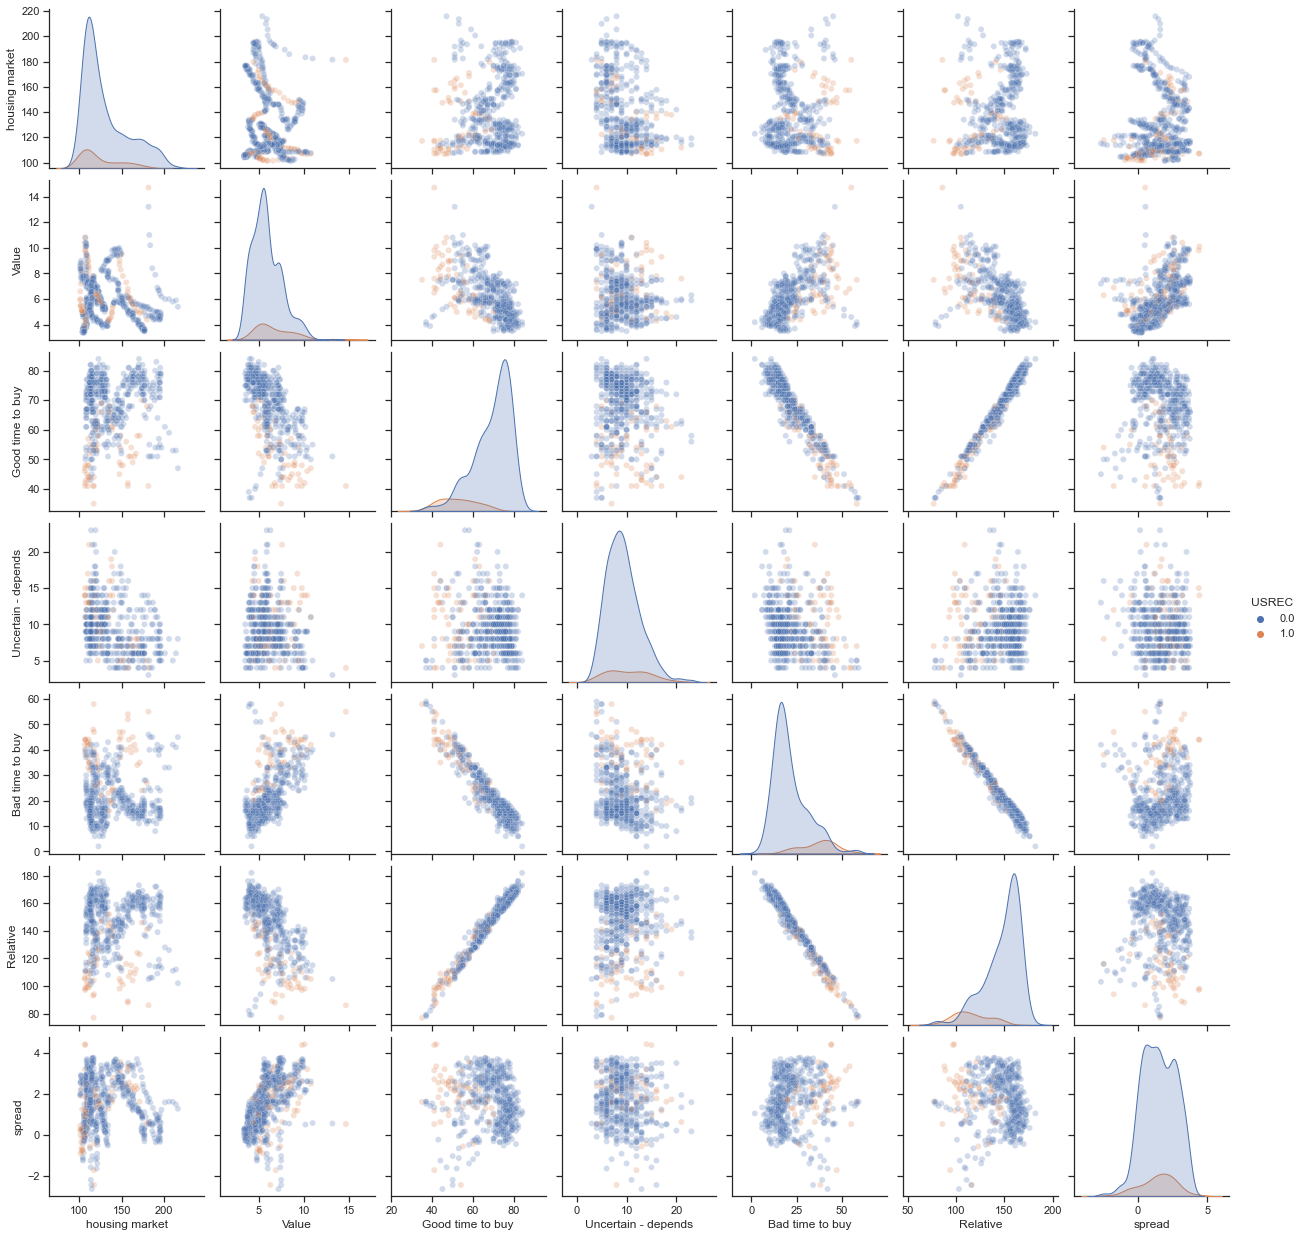

In [140]:
import seaborn as sns
sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon']), hue = 'USREC', plot_kws={'alpha': 0.25});
#Hex distribution

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier


sm = SMOTE(random_state=42)
X = data.drop(columns = ['USREC'])
y = data['USREC']
smpl = SimpleImputer(strategy = 'median')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=20)
X_imputed = smpl.fit_transform(X_train)
X_train, y_train = sm.fit_resample(X_imputed, y_train)

In [142]:
steps = [('imputer', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler()), ('rgsr', LogisticRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('rgsr', LogisticRegression())])

In [143]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [144]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_test_pred)

0.7291666666666666

In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

conf = confusion_matrix(y_train,y_train_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(conf)
#disp.plot()

Area under the curve:  0.7887


/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


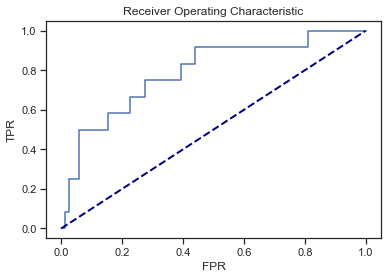

In [146]:
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve: ',round(aucscore,4));

In [147]:
y_probas = pipe.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > 0.5 else 0 for y in y_probas]
y_probas = pipe.predict_proba(X_train)[:,1]
custom_thresh_y_pred_train = [1 if y > 0.5 else 0 for y in y_probas]

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


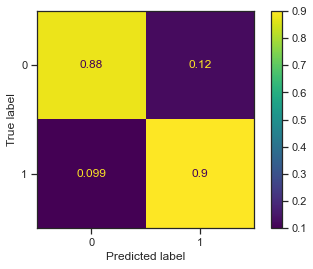

In [160]:
import numpy as np
conf = confusion_matrix(y_train,np.array(custom_thresh_y_pred_train), normalize='true')
disp = ConfusionMatrixDisplay(conf)
disp.plot();

In [149]:
from sklearn.metrics import classification_report
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)

In [153]:
report

{'0.0': {'precision': 0.953125,
  'recall': 0.7261904761904762,
  'f1-score': 0.8243243243243242,
  'support': 84},
 '1.0': {'precision': 0.28125,
  'recall': 0.75,
  'f1-score': 0.4090909090909091,
  'support': 12},
 'accuracy': 0.7291666666666666,
 'macro avg': {'precision': 0.6171875,
  'recall': 0.7380952380952381,
  'f1-score': 0.6167076167076166,
  'support': 96},
 'weighted avg': {'precision': 0.869140625,
  'recall': 0.7291666666666666,
  'f1-score': 0.7724201474201474,
  'support': 96}}

In [154]:
report['0.0']

{'precision': 0.953125,
 'recall': 0.7261904761904762,
 'f1-score': 0.8243243243243242,
 'support': 84}

In [155]:
report['1.0']

{'precision': 0.28125,
 'recall': 0.75,
 'f1-score': 0.4090909090909091,
 'support': 12}

In [156]:

X_test_imputed = pd.DataFrame(smpl.transform(X_test), columns = X_test.columns, index = X_test.index)
X_test_imputed.loc[X_test.index.sort_values()[-1],:]

housing market_mean          116.416636
Value_mean                     4.833333
Good time to buy_mean         42.000000
Uncertain - depends_mean       5.666667
Bad time to buy_mean          52.333333
Relative_mean                 89.666667
Value_3mon_mean                0.049483
Value_10yr_mean                1.413481
spread_mean                    1.363998
housing market_std             0.374379
Value_std                      0.321455
Good time to buy_std           2.645751
Uncertain - depends_std        2.081666
Bad time to buy_std            2.309401
Relative_std                   4.509250
Value_3mon_std                 0.006686
Value_10yr_std                 0.153370
spread_std                     0.153322
housing market_split           0.726892
Value_split                    0.600000
Good time to buy_split         5.000000
Uncertain - depends_split      4.000000
Bad time to buy_split          4.000000
Relative_split                 9.000000
Value_3mon_split               0.012641


In [157]:
pipe.predict_proba([X_test_imputed.loc[X_test.index.sort_values()[-1],:]])

array([[0.01004968, 0.98995032]])